In [22]:
import numpy as np
import scipy.constants as sc 
import matplotlib.pyplot as plt
module('load','cuda/11.4')

First we should ensure some source of plasma data. In this generic example we use analytical tokamak equilibrium (see `q_Equilibrium` source where symolic python is used to generate q-profile based equilibrium magnetic field)

In [2]:
import sys,os; sys.path.insert(0, os.path.expanduser('lib_misc/')) #Path to the CUWA libraries folder
import q_Equilibrium
eq = q_Equilibrium.q_Equilibrium(B0=-2.5, R0 = 1., a =0.5, q0=1.1, qa=2.0, do_lambdify=False, backend='cython')

Object `eq` is used by the ray tracing module. Here is an exmaple of reading the local magnetic field and flux

In [3]:
r = np.array([1.1,0,0])
s, B = eq.get_B(r)
print('Normilised flux:', s)
print('Magnetic field', B)

Normilised flux: 0.03741427878845727
Magnetic field [ 0.         -2.27272727  0.20765244]


Having the configuration data we also generate the density profile (its derivative is also required for ray tracing):

In [4]:
n0 = 3e20
import sympy as sp
s = sp.symbols('s',positive=True)

n_S    = n0 * 1./(1.+sp.exp(-(1.-(s+0.2))*24))+1e17
dndr_S = n_S.diff(s)
ne       = sp.lambdify((s),n_S)
dne_ds   = sp.lambdify((s),dndr_S)

Above we avoided having 0 density outside of plasma. This will be needed to determin the polarisation of the launched waves properly.

In [5]:
launcher_location = np.array((1.75,  0.,  0.))
w_0               = 140* 1e9 * 2. * np.pi

To conduct the prelimenary WKB search of the OX conversion window we launch many WKB rays and use minimisation algorithm to minimize the argument of the Mjolhus 1984 conversion formula.

In [6]:
sys.path.insert(0, os.path.expanduser('lib_misc/'))
import Ray_Tracing_cold_v1 as rt
ODEs = rt.Ray_Tracing_ODE()

In [7]:
from scipy.optimize import fmin
initial_simplex=np.array([[0,20],[0,30],[10,20]])
trac_guess = fmin(rt.search_launches,np.array([0,0]),
                  args=(launcher_location,eq,ne,dne_ds,w_0,ODEs,),xtol=0.25,ftol=0.01,
                  initial_simplex=initial_simplex)

Computation time: 0.4805863529909402 s
0.0 20.0 17.74855976808495 1.9583866095475597e-08
Computation time: 0.43302760797087103 s
0.0 30.0 8.560712170555187 0.00019148287660358492
Computation time: 0.442328960984014 s
10.0 20.0 49.78207684345373 2.398384060404278e-22
Computation time: 0.4527519829571247 s
-10.0 30.0 6.425528584551392 0.0016196769154235107
Computation time: 0.3820699630305171 s
-20.0 35.0 18.201234035938825 1.2453874770146562e-08
Computation time: 0.38739899289794266 s
-10.0 40.0 16.085759779022847 1.0328643572036828e-07
Computation time: 0.5053404270438477 s
-7.5 35.0 10.35229053761126 3.191959295145866e-05
Computation time: 0.47069216205272824 s
-2.5 25.0 4.155176388124209 0.01568302458634683
Computation time: 0.49998491699807346 s
0.0 20.0 17.74855976808495 1.9583866095475597e-08
Computation time: 0.47432319493964314 s
-12.5 25.0 4.794810787398601 0.008272563953041252
Computation time: 0.41807635698933154 s
-5.0 20.0 5.043764978515932 0.006449420620320808
Computation 

The launching angles found are:

In [8]:
trac_guess

array([-7.1206975 , 23.45566273])

Let's see that this ray is, by launching it

In [9]:
direction = rt.W7X_aiming_to_Cart(trac_guess[0]/180.*np.pi, trac_guess[1]/180.*np.pi, launcher_location)
ray       = rt.launch_wave_NzXYZ(launcher_location,direction,'O',w_0,
                                 eq,ne,dne_ds=dne_ds,ODEs=ODEs,hit_ground_s=1.05)
rays_lab = [ray.y]

Computation time: 0.7141397030791268 s


Plotting the $N_\perp$ first to make sure it is indeed close to 0 at conversion point

Text(0.5, 0, 'Path [m]')

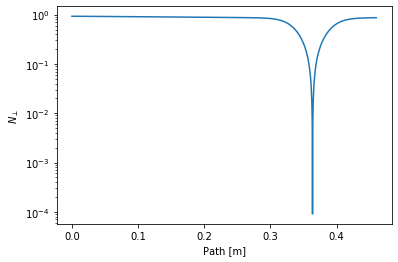

In [10]:
N_z,N_x,s,wc,wp2= rt.ray_to_stix(rays_lab[0],eq,ne,w_0)
plt.semilogy(rt.path(rays_lab[0]),N_x)
plt.ylabel(r'$N_\perp$')
plt.xlabel('Path [m]')

And the Mjolhus1984 conversion is of course equal 0.99 or so

In [11]:
T, lnT, XYZ_conv, N_conv, N_z_conv, Ln = rt.Mjolhus1984(rays_lab[0],eq,ne,dne_ds,w_0)
print(T)

0.9978575515548441


In [12]:
theta = np.linspace(0,2.*np.pi,100)
phi   = np.linspace(4.07*np.pi/2,5*np.pi/2,100)
T, P = np.meshgrid(theta, phi)
LCFS = eq.mag2xyz(1.,T,P)

s_cutoff = eq.get_B(XYZ_conv)[0]
XYZ_cutoff = eq.mag2xyz(s_cutoff,T,P)

#pip install ipyvolume
import ipyvolume as ipv
fig = ipv.figure(height=600, width=800)

lcs   = ipv.plot_surface(LCFS[0],LCFS[1],LCFS[2],color='lightgray')
lcs   = ipv.plot_surface(XYZ_cutoff[0],XYZ_cutoff[1],XYZ_cutoff[2],color='lightgray')

rcs   = ipv.scatter(ray.y[0],ray.y[1],ray.y[2],color='blue',size=1.5,marker='sphere')

ipv.xlim(np.min(ray.y[0]), np.max(ray.y[0]))
ipv.ylim(np.min(ray.y[1]), np.max(ray.y[1]))
ipv.zlim(np.min(ray.y[2]), np.max(ray.y[2]))

ipv.squarelim()
#ipv.style.box_off()
#ipv.style.axes_off()
ipv.show()

Having the setup we move to fullwave.
Following the README example we import the CUWA lib and a class used to manipulate Gaussian initial conditions

In [13]:
import sys,os; sys.path.insert(0, os.path.expanduser('./lib_CUWA/')) #Path to the CUWA libraries folder
import lib_CUWA_core as lib_CUWA #This library contains minimal code needed to run CUWA
import gaussian_beam

The Gaussian beam will be located a bit closed to `s=1`, to save on the computations. The `gaussian_focus` location is chosen arbitrary here.

In [14]:
beam = gaussian_beam.GaussianBeam(frequency_GHz = w_0/(1e9 * 2. * np.pi),
                                  mode          = 'O',
                                  origin        = launcher_location + 0.27 * direction,
                                  gaussian_focus= launcher_location + 0.4 * direction,
                                  waist_radius  = 0.02)

In [15]:
C1 = lib_CUWA.CUWA() # Initialisation of CUWA. When running on local GPU the GPU context is initialised 

15.4 GB is free of total 15.7 GB


Computation box will be generated with y-axis along the k_lab and so that the ray lays mostely on the x-y plane.

In [16]:
#Choosing the x_box and y_box basis vectors 
y_box = beam.k_lab #y_box = -eq.grad_B_grad_s(beam.origin)[3]/np.linalg.norm(eq.grad_B_grad_s(beam.origin)[3])
x_box = ray.y[0:3,-1]-beam.origin
x_box = x_box - y_box * np.dot(x_box,y_box) #Computation box X vector
x_box = x_box/np.linalg.norm(x_box)


X_sm,Y_sm,Z_sm = C1.set_comp_grid(omega_ref = beam.w_0, 
                             vac_resolution = 12,
                        low_resolution_zoom = 8,
                                     origin = beam.origin, 
                                        e_x = x_box, 
                                        e_y = y_box, 
                                    x_range = (-0.03,0.07), 
                                    y_range = (0.0,0.125), 
                                    z_thick = 0.06)
#X,Y,Z = C1.get_fine_grid()
C1.GPU_mem_requred

'8.3 Gb of memory is required excluding (minor) CPML and diagnostics.'

In [17]:
theta = np.linspace(0,2.*np.pi,100)
phi   = np.linspace(4.07*np.pi/2,5*np.pi/2,100)
T, P = np.meshgrid(theta, phi)
LCFS = eq.mag2xyz(1.,T,P)

s_cutoff = eq.get_B(XYZ_conv)[0]
XYZ_cutoff = eq.mag2xyz(s_cutoff,T,P)

import ipyvolume as ipv
fig = ipv.figure(height=600, width=800)

lcs   = ipv.plot_surface(LCFS[0],LCFS[1],LCFS[2],color='lightgray')
lcs   = ipv.plot_surface(XYZ_cutoff[0],XYZ_cutoff[1],XYZ_cutoff[2],color='lightgray')

rcs   = ipv.scatter(ray.y[0],ray.y[1],ray.y[2],color='blue',size=1.5,marker='sphere')
sd = 4
frame = ipv.plot_wireframe(X_sm[0,::sd,::sd],Y_sm[0,::sd,::sd],Z_sm[0,::sd,::sd])
frame = ipv.plot_wireframe(X_sm[-1,::sd,::sd],Y_sm[-1,::sd,::sd],Z_sm[-1,::sd,::sd])


ipv.xlim(np.min(ray.y[0]), np.max(ray.y[0]))
ipv.ylim(np.min(ray.y[1]), np.max(ray.y[1]))
ipv.zlim(np.min(ray.y[2]), np.max(ray.y[2]))

ipv.squarelim()
#ipv.style.box_off()
#ipv.style.axes_off()
ipv.show()

Now we pre-fill this grid with the data:

In [18]:
s, B_lab    = eq.get_s_B(X_sm,Y_sm,Z_sm)
modB        = np.linalg.norm(B_lab,axis=3)

In [19]:
import scipy.constants as sc
w_p = sc.e * np.sqrt(ne(s) /(sc.m_e * sc.epsilon_0))
w_c = sc.e / sc.m_e * modB
b_x,b_y,b_z = np.einsum('ij,abcj->iabc',C1.M_lab_to_box,B_lab)/modB #do not forget to rotate B vec to box frame

We have all the data we need for fullwave. So

In [20]:
C1.set_plasma_data(w_p, w_c, b_x, b_y, b_z, rampDown_width = 25)
C1.sources = []; C1.receivers = []
C1.set_antenna(beam, boundary='y_min', source= True, receiver = False)

Currently `J_intrpolate=0` behaves ok with `rampDown_width = 25`. 
`J_intrpolate=1`  with `rampDown_width = 0`

In [23]:
C1.import_cu_source(J_intrpolate=0, Jdt=2, PEC = ['yN']) # jit-compilation of cuda source code
C1.init_wave_fields() # this is where E,H,J0,J and PML fields are initialized as zeros on GPU 
C1.init_diag_fields(Surface_Poynting=False,Poynting=True) # this is where auxlilary fields are initialized 

In [24]:
import progressbar #pip install progressbar2
steps = C1.suggested_n_steps
for t in progressbar.progressbar(range(steps)):
    for source in C1.sources:
        C1.run_source(t,source)
    C1.run_step()
    C1.integrate_S(t,steps)

100% (5888 of 5888) |####################| Elapsed Time: 0:10:25 Time:  0:10:25


In [25]:
if C1.Poynting:
    S_L, S_R, S_B, S_T, S_B0 = C1.intensities_from_S()
    print((S_L+ S_R+ S_B+ S_T)/S_B0)
if C1.Surface_Poynting:
    S_L, S_R, S_B, S_T, S_B0 = C1.intensities_from_S_surfaces()
    print((S_L- S_R+ S_B- S_T)/S_B0)

0.71426976


In [26]:
E = C1.get_magE()

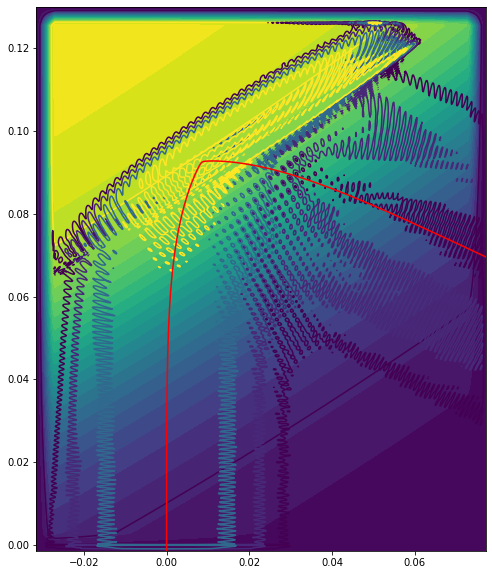

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.contourf(C1.cX_box,C1.cY_box,C1.w_p[0],30)
ax1.contour(C1.cX_box,C1.cY_box,C1.w_p[0]/beam.w_0,[0.1,1.])
#ax1.contour(C1.cX_box,C1.cY_box,C1.w_p[0]/w_0,[0.1,1.])
ax1.contour(C1.cX_box,C1.cY_box,E[C1.Size_Z//2],[0.05,0.1,0.2,0.5])
r_ray_box, N_ray_box = C1.ray_to_box(ray.y)
ax1.plot(r_ray_box[0],r_ray_box[1],'r')
ax1.set_aspect('equal')
ax1.set_xlim((C1.cX_box[0],C1.cX_box[-1]))
ax1.set_ylim((C1.cY_box[0],C1.cY_box[-1]))
#b20 = np.dot(C1.M_lab_to_box,(beam2.new_source_loc-C1.origin))
#ax1.scatter(b20[0],b20[1])

plt.show()

And here is how you save everything to Paraview format.

In [28]:
folder = 'tmp/'
from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=True)
C1.save_plasma_data_h5(folder=folder,extra_fields={'s': s})
C1.save_results_h5(folder=folder)
#C1.save_surface_poynting_h5(folder=folder)

import lib_CUWA_io
lib_CUWA_io.Write_VTP(folder+'WKB.vtp',[C1.ray_to_box(rays_lab[0])[0]])

In [29]:
theta = np.linspace(0,2.*np.pi,100)
phi   = np.linspace(4.07*np.pi/2,5*np.pi/2,100)
T, P = np.meshgrid(theta, phi)
LCFS = eq.mag2xyz(1.,T,P)

s_cutoff = eq.get_B(XYZ_conv)[0]
XYZ_cutoff = eq.mag2xyz(s_cutoff,T,P)

import ipyvolume as ipv
fig = ipv.figure(height=600, width=800)

lcs   = ipv.plot_surface(LCFS[0],LCFS[1],LCFS[2],color='lightgray')
lcs   = ipv.plot_surface(XYZ_cutoff[0],XYZ_cutoff[1],XYZ_cutoff[2],color='lightgray')

rcs   = ipv.scatter(ray.y[0],ray.y[1],ray.y[2],color='blue',size=1.5,marker='sphere')

from skimage import measure
#verts, faces, normals, values = measure.marching_cubes(E.T, 0.2, spacing=(C1.dx, C1.dx, C1.dx),step_size=10)
verts, faces, normals, values = measure.marching_cubes_lewiner(E.T, 0.2, spacing=(C1.dx, C1.dx, C1.dx), step_size=10)
box_x0y0z0 = np.array([C1.cX_box[0],C1.cY_box[0],C1.cZ_box[0]])
verts_lab = np.dot(C1.M_box_to_lab,verts.T + box_x0y0z0[:,None])+C1.origin[:,None]

sol   = ipv.plot_trisurf(verts_lab[0],verts_lab[1],verts_lab[2],triangles = faces)

ipv.xlim(np.min(C1.x_lab_sl), np.max(C1.x_lab_sl))
ipv.ylim(np.min(C1.y_lab_sl), np.max(C1.y_lab_sl))
ipv.zlim(np.min(C1.z_lab_sl), np.max(C1.z_lab_sl))
ipv.squarelim()
#ipv.style.box_off()
#ipv.style.axes_off()
ipv.show()